In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

# Figure 2, walltime

In [135]:
%run ../scripts/bench_to_csv.py
THREADS = [1, 2, 4, 8, 16, 32]

In [136]:
summary_io = parse_exp('just-io', range(1, 10), dir='../benchmarks')
summary_hll = parse_exp('unique-kmers', range(1, 10), threads=THREADS, dir='../benchmarks')

In [154]:
constant_line_walltime = None
for t in THREADS:
    df = summary_io[['replicate', 'Elapsed (wall clock) time (seconds)', 'threads']].copy()
    df['threads'] = t
    df['condition'] = 'Just I/O'
    if constant_line_walltime is None:
        constant_line_walltime = df
    else:
        constant_line_walltime = constant_line_walltime.append(df, ignore_index=True)

plot_hll = summary_hll[['replicate', 'Elapsed (wall clock) time (seconds)', 'threads']].copy()
plot_hll['condition'] = 'Parallel HLL'

plot_data = plot_hll.append(constant_line_walltime, ignore_index=True)

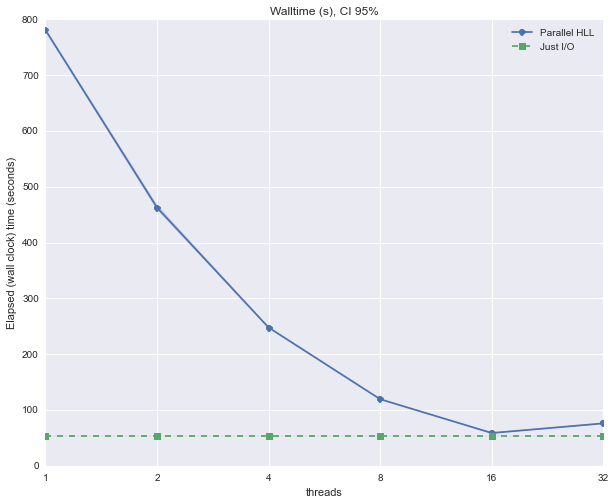

In [155]:
majorFormatter = FormatStrFormatter('%d')

fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
sns.tsplot(plot_data, ax=ax, ci=95, 
           err_style='ci_band', 
           #err_style="unit_traces",
           linestyle='-', marker='o',
           time="threads", unit='replicate', condition='condition',
           value="Elapsed (wall clock) time (seconds)")
ax.lines[-1].set_linestyle("--")
ax.lines[-1].set_marker("s")
ax.set_xscale("log", basex=2)
ax.xaxis.set_major_formatter(majorFormatter)

#ax.set_yscale("log", basey=2)
#ax.yaxis.set_major_formatter(majorFormatter)

ax.legend(loc='best')
ax.set_title("Walltime (s), CI 95%")
fig.savefig('../manuscript/figures/io_bound.png')

# Figure 2, speedup

In [156]:
speedup_base_hll = plot_data[(plot_data["threads"] == 1) & (plot_data["condition"] == "Parallel HLL")]["Elapsed (wall clock) time (seconds)"].median()
speedup_base_io = plot_data[(plot_data["threads"] == 1) & (plot_data["condition"] == "Just I/O")]["Elapsed (wall clock) time (seconds)"].median()

In [157]:
plot_data['speedup'] = speedup_base_hll / plot_data["Elapsed (wall clock) time (seconds)"]

plot_data.loc[(plot_data['condition'] == "Just I/O", "speedup")] = speedup_base_io / plot_data.loc[(plot_data['condition'] == "Just I/O")]["Elapsed (wall clock) time (seconds)"]

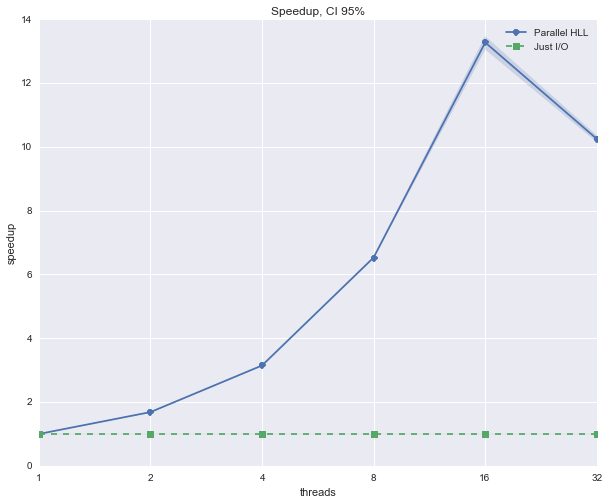

In [161]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
sns.tsplot(plot_data, ax=ax, ci=95, 
           err_style='ci_band', 
           #err_style="unit_traces",
           linestyle='-', marker='o',
           time="threads", unit='replicate', condition='condition',
           value="speedup")
ax.lines[-1].set_linestyle("--")
ax.lines[-1].set_marker("s")
ax.set_xscale("log", basex=2)
ax.xaxis.set_major_formatter(majorFormatter)

#ax.set_yscale("log", basey=2)
#ax.yaxis.set_major_formatter(majorFormatter)

ax.legend(loc='best')
ax.set_title("Speedup, CI 95%")
fig.savefig('../manuscript/figures/io_bound.png')

In [162]:
summary_io['Elapsed (wall clock) time (seconds)'].describe()

count     9.000000
mean     53.208889
std       0.034801
min      53.140000
25%      53.190000
50%      53.200000
75%      53.240000
max      53.250000
Name: Elapsed (wall clock) time (seconds), dtype: float64

In [163]:
(summary_hll[['Elapsed (wall clock) time (seconds)', 'threads']]
   .groupby('threads')
   .describe())

Elapsed (wall clock) time (seconds)
threads                                           
1       count                             9.000000
        mean                            781.134444
        std                               3.929860
        min                             777.420000
        25%                             777.700000
        50%                             779.460000
        75%                             783.500000
        max                             787.450000
2       count                             9.000000
        mean                            462.877778
        std                               7.234229
        min                             452.340000
        25%                             459.970000
        50%                             462.090000
        75%                             462.860000
        max                             479.120000
4       count                             9.000000
        mean                            247.801111
        std                               1.595709
        min                             244.760000
        25%                             247.240000
        50%                             248.010000
        75%                             249.040000
        max                             249.720000
8       count                             9.000000
        mean                            119.331111
        std                               0.626088
        min                             118.540000
        25%                             118.890000
        50%                             119.150000
        75%                             119.800000
        max                             120.400000
16      count                             9.000000
        mean                             58.740000
        std                               1.475619
        min                              57.290000
        25%                              57.580000
        50%                              58.240000
        75%                              59.250000
        max                              61.340000
32      count                             9.000000
        mean                             76.050000
        std                               1.206700
        min                              73.830000
        25%                              75.160000
        50%                              76.350000
        75%                              76.840000
        max                              77.520000

# Figure 3, memory consumption

In [164]:
constant_line_mem = None
for t in THREADS:
    df = summary_io[['replicate', 'Maximum resident set size (kbytes)', 'threads']].copy()
    df['threads'] = t
    df['condition'] = 'Just I/O'
    if constant_line_mem is None:
        constant_line_mem = df
    else:
        constant_line_mem = constant_line_mem.append(df, ignore_index=True)

plot_hll = summary_hll[['replicate', 'Maximum resident set size (kbytes)', 'threads']].copy()
plot_hll['condition'] = 'Parallel HLL'

plot_data = plot_hll.append(constant_line_mem, ignore_index=True)

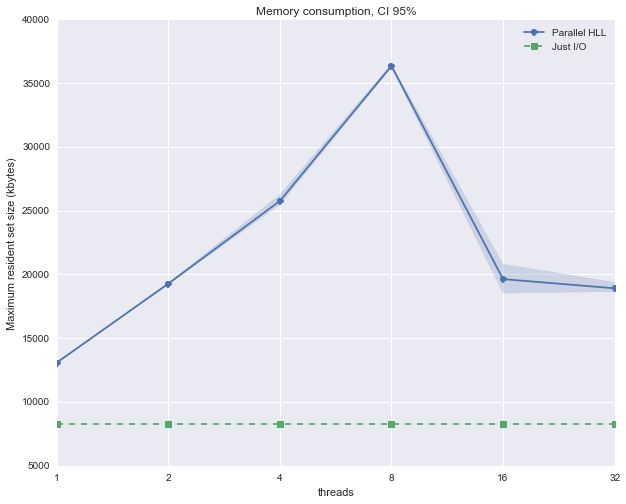

In [165]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
sns.tsplot(plot_data, ax=ax, ci=95, err_style='ci_band',
           #err_style="unit_traces",
           time="threads", unit='replicate', condition='condition',
           linestyle='-', marker='o',
           value="Maximum resident set size (kbytes)")
ax.lines[-1].set_linestyle("--")
ax.lines[-1].set_marker("s")
ax.set_xscale("log", basex=2)
ax.xaxis.set_major_formatter(majorFormatter)

ax.set_title("Memory consumption, CI 95%")
ax.legend(loc='best')
fig.savefig('../manuscript/figures/mem_consumption.png')

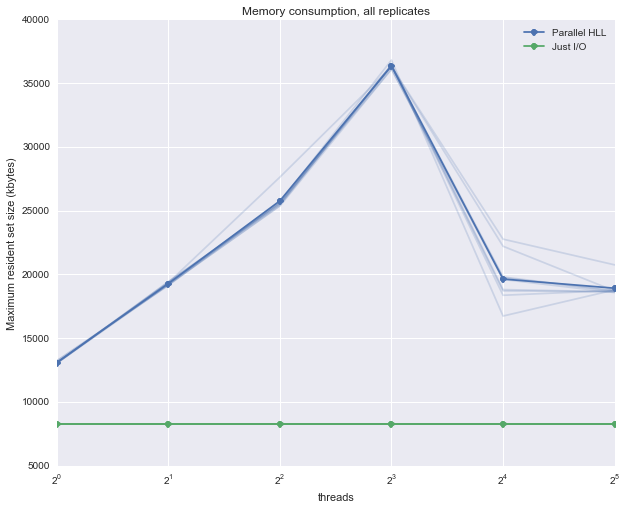

In [168]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
sns.tsplot(plot_data, ax=ax, ci=95, err_style="unit_traces",
           time="threads", unit='replicate', condition='condition',
           linestyle='-', marker='o',
           value="Maximum resident set size (kbytes)")
ax.set_xscale("log", basex=2)
ax.legend(loc='best')
ax.set_title("Memory consumption, all replicates")
fig.savefig('../manuscript/figures/mem_consumption_unit_traces.png')

In [167]:
summary_io['Maximum resident set size (kbytes)'].describe()

count       9.000000
mean     8244.000000
std         2.828427
min      8240.000000
25%      8244.000000
50%      8244.000000
75%      8244.000000
max      8248.000000
Name: Maximum resident set size (kbytes), dtype: float64

In [133]:
(summary_hll[['Maximum resident set size (kbytes)', 'threads']]
   .groupby('threads')
   .describe())

Maximum resident set size (kbytes)
threads                                          
1       count                            9.000000
        mean                         13082.222222
        std                             77.333333
        min                          13020.000000
        25%                          13032.000000
        50%                          13056.000000
        75%                          13064.000000
        max                          13216.000000
2       count                            9.000000
        mean                         19276.888889
        std                            107.084598
        min                          19124.000000
        25%                          19192.000000
        50%                          19300.000000
        75%                          19340.000000
        max                          19420.000000
4       count                            9.000000
        mean                         25764.444444
        std                            705.150890
        min                          25360.000000
        25%                          25496.000000
        50%                          25560.000000
        75%                          25652.000000
        max                          27624.000000
8       count                            9.000000
        mean                         36352.888889
        std                            212.638452
        min                          36092.000000
        25%                          36272.000000
        50%                          36360.000000
        75%                          36420.000000
        max                          36804.000000
16      count                            9.000000
        mean                         19636.888889
        std                           1871.264575
        min                          16736.000000
        25%                          18708.000000
        50%                          19604.000000
        75%                          19800.000000
        max                          22764.000000
32      count                            9.000000
        mean                         18916.888889
        std                            689.509326
        min                          18576.000000
        25%                          18644.000000
        50%                          18704.000000
        75%                          18744.000000
        max                          20748.000000